# Forecasting del precio del gas natural en Houston Ship Channel



In [1]:
import warnings
import itertools
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import statsmodels.api as sm
import matplotlib
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
%matplotlib inline

/home/ulises/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Importacion del dataset

In [2]:
df = pd.read_csv(r"/home/ulises/Documentos/Forecasting/GAS.csv")
df.head()

,FECHA,HH,HSC
0,01/01/13,3.425,3.33
1,02/01/13,3.425,3.33
2,03/01/13,3.300,3.22
3,04/01/13,3.195,3.08
4,05/01/13,3.205,3.12


In [3]:
df['FECHA'].min(), df['FECHA'].max()

('01/01/13', '31/12/17')

In [4]:
df.drop(['HH'], axis=1, inplace=True)


In [5]:
df.isnull().sum()

FECHA    0
HSC      0
dtype: int64

### Formato de fecha

In [6]:
df['FECHA']=pd.to_datetime(df['FECHA'],dayfirst=True)

In [7]:
df = df.set_index('FECHA')
df.head()

,HSC
FECHA,
2013-01-01,3.33
2013-01-02,3.33
2013-01-03,3.22
2013-01-04,3.08
2013-01-05,3.12


## Forecasting con XGBOOST 

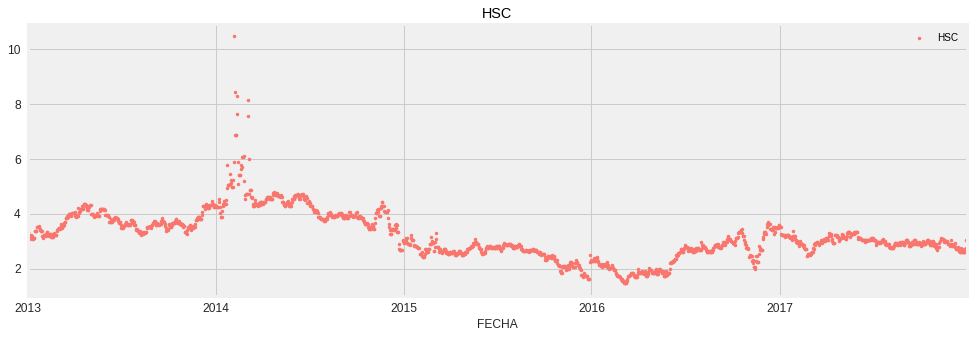

In [8]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = df.plot(style='.', figsize=(15,5), color=color_pal[0], title='HSC')

In [9]:
split_date = '2017-01-01'
#start_date = '2015-01-01'
hsc_train = df.loc[df.index <= split_date].copy()
#hsc_train=hsc_train.loc[hsc_train.index>=start_date].copy()
hsc_test = df.loc[df.index > split_date].copy()

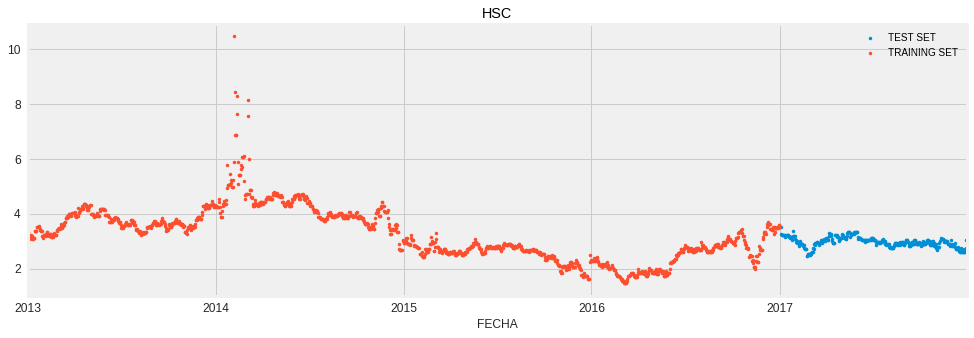

In [10]:
_ = hsc_test.rename(columns={'HSC': 'TEST SET'}) .join(hsc_train.rename(columns={'HSC': 'TRAINING SET'}), how='outer').plot(figsize=(15,5), title='HSC', style='.')

In [11]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [12]:
X_train, y_train = create_features(hsc_train, label='HSC')
X_test, y_test = create_features(hsc_test, label='HSC')

In [13]:
#parameter_space = {
#    'max_depth':range(0,100,10), 'eta': np.arange(0.015,0.6,0.15),'colsample_bytree':np.arange(0,1,0.2),'min_child_weight':range(0,11,1)}
#
#regressor = xgb.XGBRegressor(booster='gbtree',n_estimators=1000)
#regg = GridSearchCV(regressor, parameter_space, n_jobs=-1, scoring='neg_mean_squared_error')
#regg.fit(X_train, y_train)
#
# #Best paramete set
#print('Best parameters found:\n', regg.best_params_)
##('Best parameters found:\n', {'eta': 0.014999999999999999, 'colsample_bytree': 0.60000000000000009, 'max_depth': 20, 'min_child_weight': 0})

In [14]:
reg = xgb.XGBRegressor(booster='gbtree',n_estimators=1000,eta=0.015, colsample_bytree=0.6,max_depth=2, min_child_weight=0)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, eta=0.015, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=0, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

### Best features

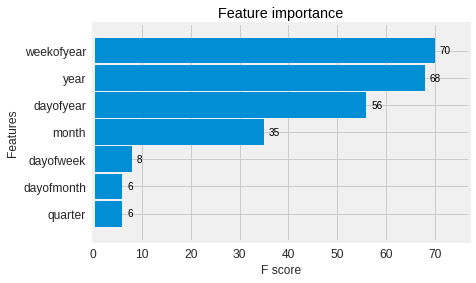

In [15]:
_ = plot_importance(reg, height=0.95)

### Implementacion del modelo

In [16]:
hsc_test['Prediction'] = reg.predict(X_test)
hsc_all = pd.concat([hsc_test, hsc_train])

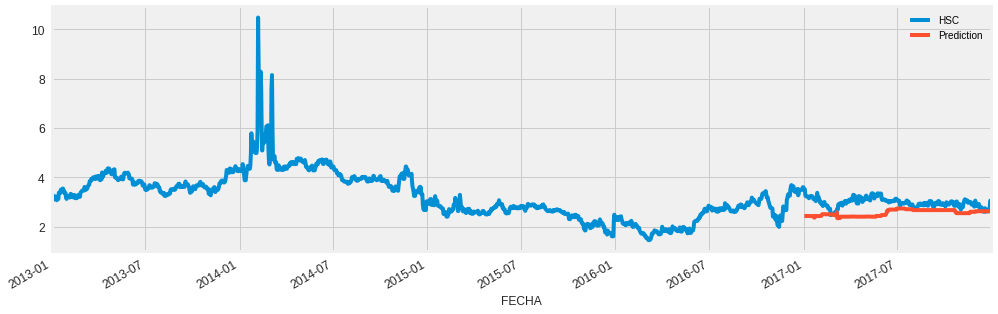

In [17]:
_ = hsc_all[['HSC','Prediction']].plot(figsize=(15, 5))

In [18]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Resultado

In [19]:
mean_absolute_percentage_error(y_true=hsc_test['HSC'],
                   y_pred=hsc_test['Prediction'])

13.706597860359684

#### De lo anterior observamos un porcentaje de error mayor al 13%
#### Una estrategia para mejorar la precision del modelo seria agregando variables relacionadas con la temperatura y clima
#### ya que el precio del gas natural depende en gran medida de ese factor

## Forecasting con series de tiempo

In [33]:
y = df['HSC'].resample('MS').mean()

In [34]:
y.head(12)

FECHA
2013-01-01    3.282742
2013-02-01    3.242857
2013-03-01    3.759194
2013-04-01    4.139333
2013-05-01    4.057903
2013-06-01    3.806833
2013-07-01    3.604194
2013-08-01    3.400806
2013-09-01    3.626167
2013-10-01    3.631290
2013-11-01    3.556833
2013-12-01    4.212581
Freq: MS, Name: HSC, dtype: float64

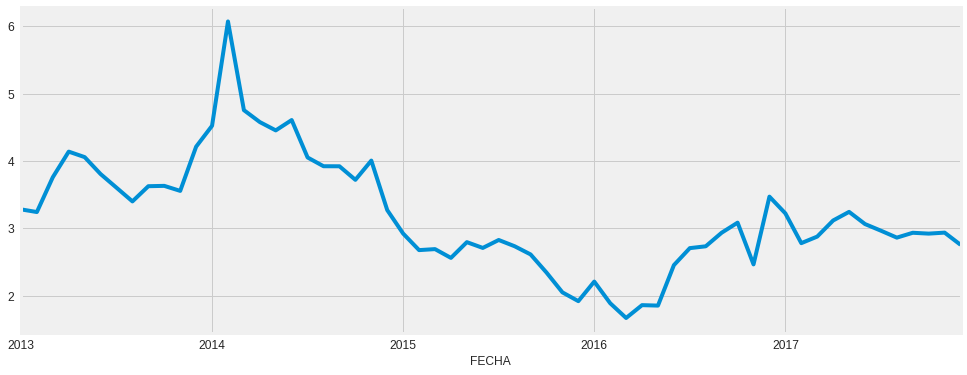

In [35]:
y.plot(figsize=(15, 6))
plt.show()

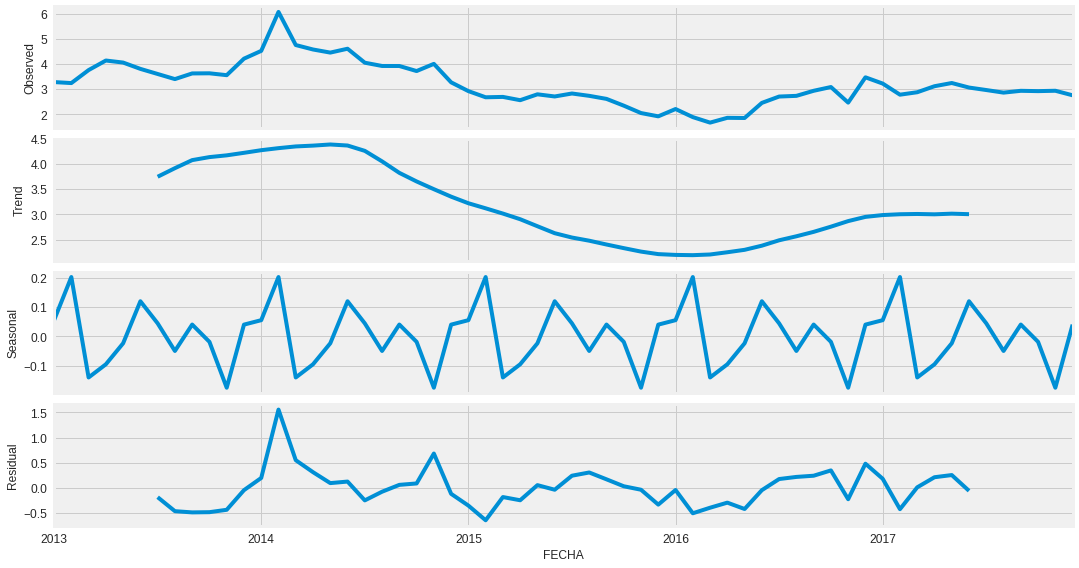

In [36]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [54]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


### Eleccion de parametros

In [40]:
par=[]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            par.append([param,param_seasonal,results.aic])
            #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
m_par=pd.DataFrame(par,columns=['order','seasonal_order','aic'])

In [41]:
tsmodel=m_par.sort_values(by='aic').reset_index()
tsmodel.head()

,index,order,seasonal_order,aic
0,25,"(0, 1, 1)","(1, 0, 1, 12)",24.733333
1,21,"(0, 1, 1)","(0, 0, 1, 12)",25.562432
2,57,"(1, 1, 1)","(1, 0, 1, 12)",26.730492
3,53,"(1, 1, 1)","(0, 0, 1, 12)",27.559440
4,56,"(1, 1, 1)","(1, 0, 0, 12)",29.695536


### Modelo

In [50]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=tsmodel['order'][0],
                                seasonal_order=tsmodel['seasonal_order'][0],
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1187      0.162     -0.735      0.462      -0.435       0.198
ar.S.L12      -0.2418      0.163     -1.484      0.138      -0.561       0.078
ma.S.L12       0.1989      0.263      0.756      0.450      -0.317       0.715
sigma2         0.0841      0.019      4.466      0.000       0.047       0.121


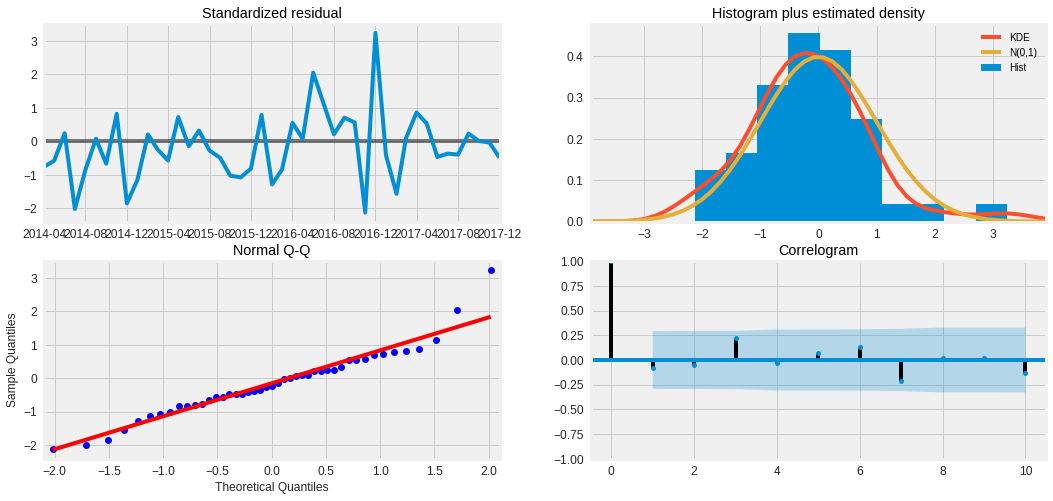

In [51]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

### Evaluacion de resultados

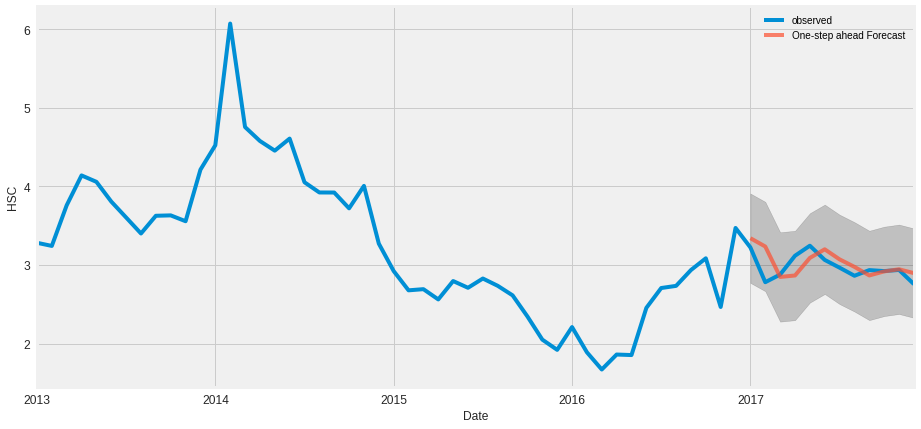

In [52]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int() #intervalos de confianza
ax = y['2013':].plot(label='observed') 
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7)) #valor promedio
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('HSC')
plt.legend()
plt.show()

In [53]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mean_absolute_percentage_error(y_true=y_truth,
                   y_pred=y_forecasted)

4.4648576619248805

#### Como era de esperarse en este caso haciendo una prediccion sobre el promedio mensual del precio se obtiene un error menor 